# Collaborative Filtering
With your best friends; Cookie Optimizers :D 

## CiteULike

In [1]:
!python -m spacy download en


    Linking successful
    C:\Users\Micha\AppData\Local\conda\conda\envs\deeplearning-02456\lib\site-packages\en_core_web_sm
    -->
    C:\Users\Micha\AppData\Local\conda\conda\envs\deeplearning-02456\lib\site-packages\spacy\data\en

    You can now load the model via spacy.load('en')



In [2]:
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator
from torchtext.vocab import Vocab
import pandas as pd
import numpy as np
import spacy

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
import torch.nn.utils.rnn as rnn_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def condence(nparr):
    uniq = np.unique(nparr)
    name2idx = {o:i for i,o in enumerate(uniq)}
    return np.array([name2idx[o] for o in nparr]), uniq

## Read set
text_information_index = 4
max_len = 1000
data='../datasets/citeulike/raw-data.csv'
#interactions = '../datasets/citeulike/user-info-small.csv'
interactions = '../datasets/citeulike/user-info.csv'
rawtext = pd.read_csv(data)
interactions = pd.read_csv(interactions)
interactions["user.id"], uniq = condence(interactions["user.id"].values)
sizes = [0.7, 0.2]

interactions = interactions.sample(frac=1) # Shuffle
filt = interactions["doc.id"].map(lambda x: len(rawtext.iloc[x,text_information_index])) <= max_len
interactions = interactions[filt]
interactions["doc.id"] = interactions["doc.id"].transform(lambda idx: rawtext.iloc[int(idx),text_information_index])

n = len(interactions)
train_size = int(sizes[0] * n)
val_size = int(sizes[1] * n)
test_size = n - train_size - val_size

train = interactions[:train_size]
val = interactions[train_size:train_size+val_size]
test = interactions[train_size+val_size:]

n = len(train)

uniq_items = np.unique(rawtext["doc.id"])[:-1]
uniq_users = np.unique(train["user.id"])[:-1]
items = set((x[0],x[1]) for x in train[["user.id","doc.id"]].values)

pairs = []
i = 0
while(i < n):
    
    item = np.random.choice(uniq_items, size = 1)[0]
    text = rawtext.iloc[int(item),text_information_index]
    user = np.random.choice(uniq_users, size = 1)[0]
    if len(text.split(' ')) <= max_len and (user,item) not in items:
        i += 1
        pairs += [(user,text,0)]
        items.add((user,item))

interactionsNegatives = np.vstack((train, pairs))

train = pd.DataFrame(data = interactionsNegatives, columns = ["user.id","doc.id", "rating"])

val.to_csv('../datasets/citeulike/val.csv', header = False, index = False)
test.to_csv('../datasets/citeulike/test.csv', header = False, index = False)

del interactionsNegatives, items, uniq_items, uniq_users, pairs, interactions, val, test

train = train.sample(frac=1) #shuffle panda style

train.to_csv('../datasets/citeulike/train.csv', header = False, index = False)

max_length = max(train["doc.id"].map(lambda x: len(x.split(' '))))
print(max_length)

del train

997


In [6]:
spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

TEXT = Field(sequential=True, lower=True, include_lengths=True, fix_length=max_length)
LABEL = Field(sequential=False, use_vocab=False)
ID = Field(sequential=False, use_vocab=False)

train, val, test = TabularDataset.splits(
        path='../datasets/citeulike', train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
        fields=[('ID', ID), ('Text', TEXT), ('Label', LABEL)])

TEXT.build_vocab(train, vectors="glove.6B.100d")
LABEL.build_vocab(train)
ID.build_vocab(train)

In [7]:
print('Text fields:')
#print('keys of TEXT.vocab:', list(TEXT.vocab.__dict__.keys()))
print(' size of vocabulary:', len(TEXT.vocab))
print(" vocabulary's embedding dimension:", TEXT.vocab.vectors.size())
print(' no. times the "the" appear in the dataset:', TEXT.vocab.freqs['the'])

Text fields:
 size of vocabulary: 144030
 vocabulary's embedding dimension: torch.Size([144030, 100])
 no. times the "the" appear in the dataset: 955129


In [8]:
batch_size = (101, 102, 103)

train_iter, val_iter, test_iter = BucketIterator.splits(
    (train, val, test), batch_sizes=batch_size, sort_key=lambda x: len(x.Text), sort_within_batch = True, repeat = False)

In [9]:
# size of embeddings
TEXT_Shape = TEXT.vocab.vectors.size()
embedding_dim = TEXT_Shape[1]
num_items = TEXT_Shape[0]
num_users = len(ID.vocab.itos)
n_hidden = 104
l1_hidden = 105

In [10]:
class CFNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=embedding_dim, n_hidden=n_hidden, l1_hidden=l1_hidden):
        super(CFNN, self).__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        self.lin1 = nn.Linear(n_hidden+embedding_dim, l1_hidden)
        self.lin2 = nn.Linear(l1_hidden, 1)
        self.drop0 = nn.Dropout(0.3)
        self.drop1 = nn.Dropout(0.3)
                
        # RNN decoding
        self.rnn = nn.LSTM(embedding_dim, n_hidden, bidirectional = True)
        self.rnnlin = nn.Linear(n_hidden*3, n_hidden)
        
        self.sigmoid = nn.Sigmoid()
        
        ## Attention module
        self.attn = nn.Linear(n_hidden*2, n_hidden)
        
    def forward(self, u, v, hidden, seq_lengths):
        #print(v.shape)
        U = self.user_emb(u)
        V = self.item_emb(v)
                
        ## Packing, Encoding, Padding
        packed = rnn_utils.pack_padded_sequence(V, seq_lengths).to(device)
        rnnOut, (hn, cn) = self.rnn(packed, hidden)
        padded, seq_lengths = rnn_utils.pad_packed_sequence(rnnOut, padding_value=0, total_length=max_length)
        seq_lengths = seq_lengths.to(device).float()
        
        # Divide each batch_element by sequence_element and sum. (mean by seq_length)
        padded = (padded.transpose(1,2) / seq_lengths).transpose(1,2)
        mean = padded.sum(dim=0)
        
        V_rnn = torch.cat([mean, hn[-1]], dim=1)
        V_rnn = F.relu(self.rnnlin(V_rnn))
                 
        x = torch.cat([U, V_rnn], dim=1)

        ## Classification
        x = self.drop0(x)
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        
        x = self.lin2(x)
        x = self.sigmoid(x)
        return x
    
    def init_hidden(self, batch_size):
        init = torch.zeros(2, batch_size, n_hidden).to(device)
        return (init,init)

In [11]:
## Training loop
def train(model, train_loader, optimizer, criterion, epoch, print_batch_p):
    model.train()
    
    acc_list = []
    loss_list = []
    
    for batch_idx, data in enumerate(train_loader):
        users = data.ID
        (items, seq_lengths) = data.Text
        ratings = data.Label
        batch_size = len(seq_lengths)
        
        users = users.long().to(device)
        items = items.long().to(device)
        ratings = ratings.float().to(device)      
        
        hidden_size = model.init_hidden(batch_size)
        optimizer.zero_grad()
        output = model(users, items, hidden_size, seq_lengths)
        loss = criterion(output, ratings)
        loss.backward()
        optimizer.step()
        
        # Print jumping
        percent = print_batch_p
        proc = int((len(train_loader.dataset)/batch_size)*percent)
        proc = proc if proc >= 1 else 1
        
        # Calculate accuracy
        TP,FP,TN,FN = 0,0,0,0
        output_flat = [0 if o < 0.5 else 1 for o in output.data]
        for y,yhat in zip(ratings.data, output_flat):
            y = int(y)
            if yhat == 0:
                if y != yhat:
                    FN += 1
                else:
                    TN += 1
            else:
                if y != yhat:
                    FP += 1
                else:
                    TP += 1
            
        acc_list += [(TP + TN)/(TP+FP+TN+FN)]
        loss_list += [loss.item()]
        
        if (batch_idx % proc == 0 and batch_idx != 0):
            loss_mean = sum(loss_list)/len(loss_list)
            acc_mean = sum(acc_list)/len(acc_list)
            percent = 100 * (batch_idx / (len(train_loader)-1))
            print(f'Train epoch {epoch:3d} ({percent:3.0f}%), Mean Accuracy: {acc_mean:2.5f}, Mean Loss: {loss_mean:2.5f}')
            
def validate(model, val_loader, criterion, epoch):
    model.eval()
    
    val_loss = 0
    TP,FP,TN,FN = 0,0,0,0
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            users = data.ID
            (items, seq_lengths) = data.Text
            ratings = data.Label
            batch_size = len(seq_lengths)
            
            users = users.long().to(device)
            items = items.long().to(device)
            ratings = ratings.float().to(device)
            
            hidden_size = model.init_hidden(batch_size)
            output = model(users, items, hidden_size, seq_lengths)
            loss = criterion(output.float(), ratings)
            
            output_flat = [0 if o < 0.5 else 1 for o in output.data]
            for y,yhat in zip(ratings.data, output_flat):
                y = int(y)
                if yhat == 0:
                    if y != yhat:
                        FN += 1
                    else:
                        TN += 1
                else:
                    if y != yhat:
                        FP += 1
                    else:
                        TP += 1
            val_loss += loss.item() # sum up batch loss

    acc = (TP + TN)/(TP + TN + FP + FN)
    val_loss /= len(val_loader)
    print(f'Validation epoch {epoch:>3d} (100%), Accucary: {acc:>2.5f}, Mean Loss: {val_loss:>2.5f} \n')
    return acc, val_loss

def trainLoop(epochs, lr=0.001, wd = 1e-6, print_batch_p = 1, early_patience=5):
    # Define model    
    model = CFNN(num_users, num_items).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
    
    accs = []
    losses = []
    best_acc = (-1,-1e16,1e16)
    best_loss = (-1,-1e16,1e16)
    early = 0
    
    for epoch in range(1, epochs + 1):
        train(model, train_iter, optimizer, criterion, epoch, print_batch_p)
        val_acc, val_loss = validate(model, val_iter, criterion, epoch)
        accs += [val_acc]
        losses += [val_loss]
        
        early += 1
        if val_acc > best_acc[-2]:
            early = 0
            best_acc = (epoch, val_acc, val_loss)
        if val_loss < best_loss[-1]:
            early = 0
            best_loss = (epoch, val_acc, val_loss)
        if early >= early_patience:
            break
        
    plt.plot(range(1,epoch+1),accs)
    plt.show()
    print(f'best validatation accu epoch: {best_acc[0]:>3.0f}, acc: {best_acc[1]:>2.5f}, mean loss: {best_acc[2]:>2.5f} \n')
    plt.plot(range(1,epoch+1),losses)
    plt.show()
    print(f'best validatation loss epoch: {best_loss[0]:>3.0f}, acc: {best_loss[1]:>2.5f}, mean loss: {best_loss[2]:>2.5f}')

Train epoch   1 ( 33%), Mean Accuracy: 0.54375, Mean Loss: 0.68458
Train epoch   1 ( 66%), Mean Accuracy: 0.57602, Mean Loss: 0.66855
Train epoch   1 ( 99%), Mean Accuracy: 0.60453, Mean Loss: 0.64690
Validation epoch   1 (100%), Accucary: 0.78538, Mean Loss: 0.51773 

Train epoch   2 ( 33%), Mean Accuracy: 0.73369, Mean Loss: 0.51975
Train epoch   2 ( 66%), Mean Accuracy: 0.74345, Mean Loss: 0.50419
Train epoch   2 ( 99%), Mean Accuracy: 0.74878, Mean Loss: 0.49382
Validation epoch   2 (100%), Accucary: 0.85623, Mean Loss: 0.42705 

Train epoch   3 ( 33%), Mean Accuracy: 0.79655, Mean Loss: 0.41543
Train epoch   3 ( 66%), Mean Accuracy: 0.79375, Mean Loss: 0.41755
Train epoch   3 ( 99%), Mean Accuracy: 0.79204, Mean Loss: 0.41871
Validation epoch   3 (100%), Accucary: 0.84179, Mean Loss: 0.43170 

Train epoch   4 ( 33%), Mean Accuracy: 0.81538, Mean Loss: 0.38268
Train epoch   4 ( 66%), Mean Accuracy: 0.80914, Mean Loss: 0.39128
Train epoch   4 ( 99%), Mean Accuracy: 0.80734, Mean Los

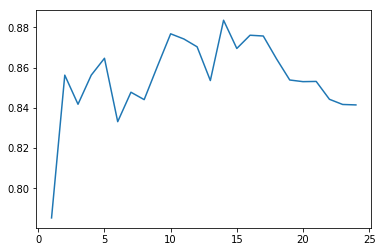

best validatation accu epoch:  14, acc: 0.88347, mean loss: 0.38802 



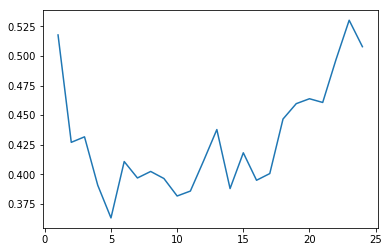

best validatation loss epoch:   5, acc: 0.86460, mean loss: 0.36323


In [12]:
trainLoop(epochs=100, lr=0.001, wd=1e-6, print_batch_p=0.33, early_patience=10)